# Aurinkopaneeleiden teknologiat

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import importlib.util
import sys

try:
  import preprocessor as esik
except ModuleNotFoundError:
  file_path = "preprocessor.py"; module_name = "preprocessor"; spec = importlib.util.spec_from_file_location(module_name, file_path)
  esik = importlib.util.module_from_spec(spec); sys.modules[module_name] = esik; spec.loader.exec_module(esik)

try:
  import columns_file as cf
except ModuleNotFoundError:
  file_path = "columns_file.py"; module_name = "columns_file"; spec = importlib.util.spec_from_file_location(module_name, file_path)
  cf = importlib.util.module_from_spec(spec); sys.modules[module_name] = cf; spec.loader.exec_module(cf)

cols = ['installation_date', 'year', 'total_installed_price', 'system_size_DC', 'price_per_kW', 'customer_segment']
cols.extend(cf.technology_module)
cols.extend(cf.efficiency_module)
cols.extend(cf.module_quantity)
cols.extend(cf.nameplate_capacity_module)
#cols = cf.all_orig()

# esikäsittelijän ajaminen aluksi vain minimal
df_all = esik.esik(cols, 'minimal')

# FormatterFunc
def no_mult(x, pos):
    """The two arguments are the value and tick position."""
    return '{:1.0f}'.format(x)

def kilo(x, pos):
    """The two arguments are the value and tick position."""
    return '{:1.1f}k'.format(x*1e-3)

# Käytetään kaikissa kuvaajissa samoja värejä
values = df_all['technology_module_1'].value_counts().index.tolist() # uniikit arvot määrien mukaan lajiteltuna (myös NaN) listaan
values += ['muut', 'arvo puuttuu'] # lisätään vielä muut-arvo
color_palette = sns.color_palette('deep')
colors = {value: list(color_palette)[i] for i, value in enumerate(values)} # määritetään jokaiselle arvolle oma väri

# Erilaisia funktiolistoja
agg_default = ['min', 'mean', 'median', 'max']
agg_extended = ['size', 'count', 'min', 'mean', 'median', 'max']
agg_means = ['mean', 'median']
agg_counts = ['size', 'count']

## Paneeliteknologioiden määrät ennen esikäsittelyä

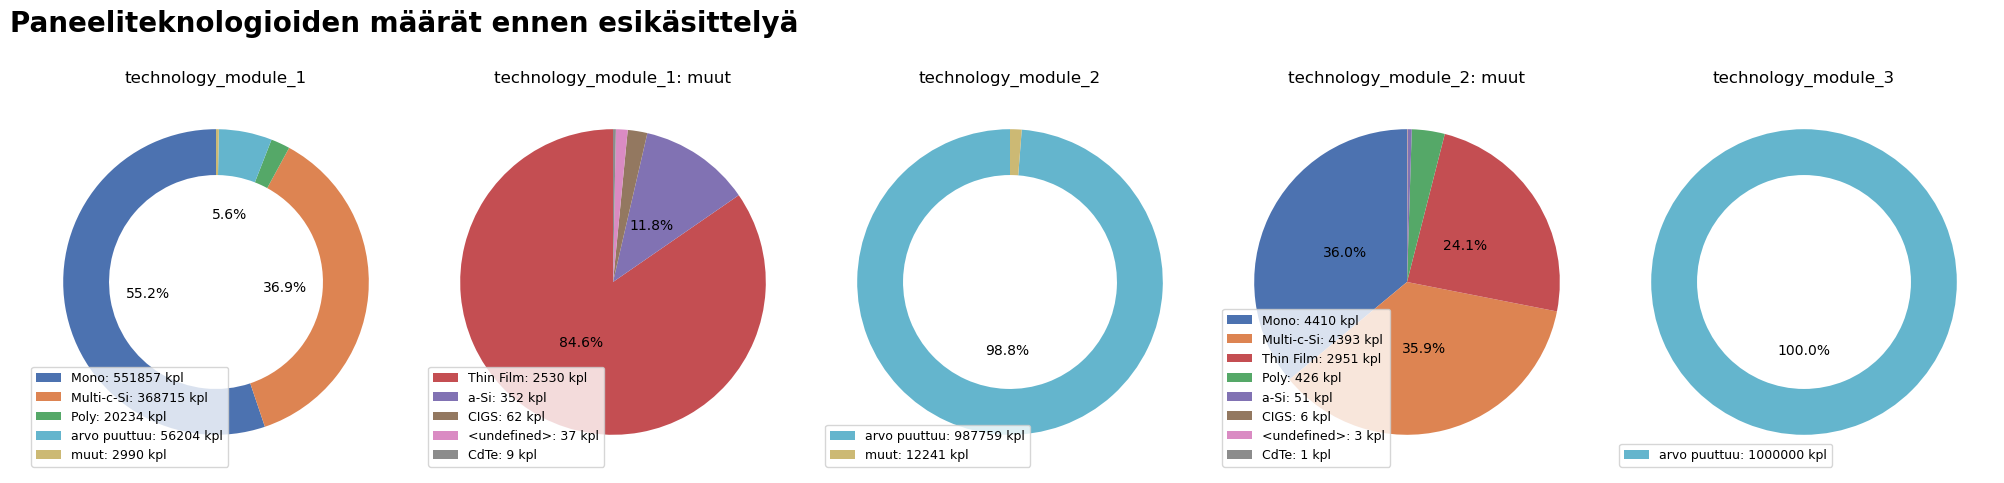

In [2]:
df = df_all.copy()
modules = cf.technology_module
df[modules] = df[modules].fillna('arvo puuttuu') # näyeteään kuvioissa NaN-arvojen tilalla tämä teksti

def pctFormat(pct): 
    return ('%.1f' % pct)+'%' if pct > 5 else '' # formatoi kuvaajien prosenttilukuja

# Kootaan kuvaajien data
pies = dict({'data':[], 'labels':[], 'colors':[], 'titles':[]})
i=0
for module in modules:
    tm = df[module].value_counts(dropna=False)
    cut = tm.sum() * 0.02
    pies['data'].insert(i, tm.groupby(np.where(tm >= cut, tm.index, 'muut')).sum()) # ryhmitellään pienet määrät muut-kategoriaan
    pies['labels'].insert(i, [f'{key}: {pies["data"][i][key]} kpl' for key in pies['data'][i].keys()]) # luodaan labelit, joissa kpl-määrät näkyvissä
    pies['colors'].insert(i, [colors[key] for key in pies['data'][i].keys()]) # haetaan värit kuvaajaan 
    pies['titles'].insert(i, module)
    i=i+1
    if(tm.min() < cut): # jos tarvitaan muut-kuvaajaa, luodaan sille data
        pies['data'].insert(i, tm.groupby(np.where(tm < cut, tm.index, 'pois')).sum().drop('pois').sort_values(ascending=0)) # jätetään vain muut näkyviin
        pies['labels'].insert(i, [f'{key}: {pies["data"][i][key]} kpl' for key in pies['data'][i].keys()]) # luodaan labelit, joissa kpl-määrät näkyvissä
        pies['colors'].insert(i, [colors[key] for key in pies['data'][i].keys()]) # haetaan värit kuvaajaan 
        pies['titles'].insert(i, module+': muut')
        i=i+1

# Piirretään kuvaajat
fig, axes= plt.subplots(1, len(pies['data']), figsize=(20, 20))
for i, ax in enumerate(axes.flatten()):
    ax.pie(pies['data'][i], colors = pies['colors'][i], autopct = pctFormat, startangle=90, pctdistance=0.45, wedgeprops=dict(width=(.3 if ((i +1) % 2) == 1 else 1)))
    ax.set_title(pies['titles'][i],)
    ax.legend(loc=3, prop={'size': 9}, labels=pies['labels'][i])
    fig = ax.get_figure()
    fig.tight_layout()
    fig.subplots_adjust(top=1.68)
plt.suptitle('Paneeliteknologioiden määrät ennen esikäsittelyä', x=0, horizontalalignment='left', fontweight ='bold', fontsize=20)
plt.show()

## Paneeliteknologioiden määrät esikäsittelyn jälkeen

* Poly ja multi-c-Si tarkoitetaan samaa Polychrystalline -teknologiaa -> yhdistetään Poly:ksi
* a-Si, CIGS js CdTe ovat Thin Film -paneelien alaluokkia ja näitä on hyvin pieniä määriä -> yhdistetään nämä Thin Film alle
* muutetaan < undefined > -arvot NaN-arvoiksi

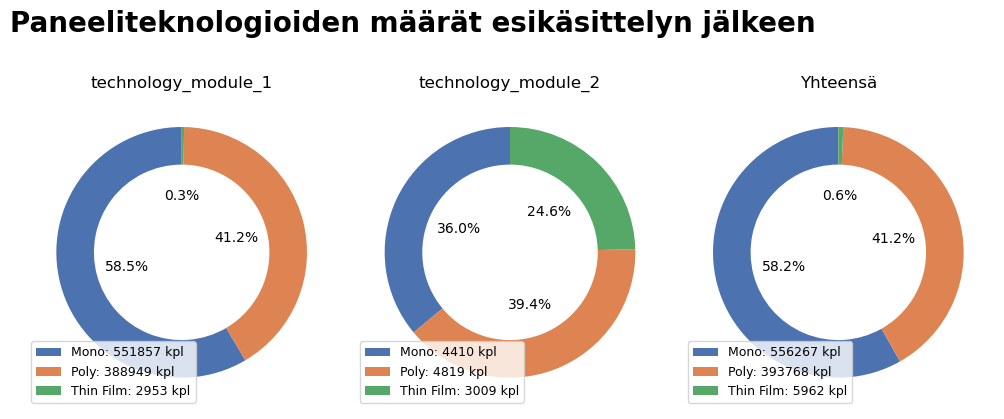

In [3]:
df = df_all.copy()
# Tietoa paneeliteknologioista: https://aurorasolar.com/blog/solar-panel-types-guide/

# esikäsittelyjä, jotka lisätty myös esikäsittelijään (prepsocessor.py)
df[modules] = df[cf.technology_module].replace('Multi-c-Si', 'Poly') # Poly ja multi-c-Si sama asia
df[modules] = df[cf.technology_module].replace(['a-Si', 'CIGS', 'CdTe'], 'Thin Film') # Thin Film -paneelien alaluokkia, yhdistetään
df[modules] = df[cf.technology_module].replace('<undefined>', np.nan) # <undefined> -arvo pois

df_all = df # päivitetään muutokset myös alussa ladattuun dataan
colors = {value: list(color_palette)[i] for i, value in enumerate(df_all['technology_module_1'].value_counts().index.tolist())} # päivitetään värit

modules = cf.technology_module[:-1] # kolmatta tyhjää saraketta ei tarvita

def pctFormat(pct): 
    return ('%.1f' % pct)+'%' if pct > 0 else '' # formatoi kuvaajien prosenttilukuja

# Kootaan kuvaajien data
pies = dict({'data':[], 'labels':[], 'colors':[], 'titles':[]})
i=0
for module in modules:
    tm = df[module].value_counts(dropna=False)
    cut = tm.sum() * 0
    pies['data'].insert(i, tm.groupby(np.where(tm >= cut, tm.index, 'muut')).sum()) # ryhmitellään pienet määrät muut-kategoriaan
    pies['labels'].insert(i, [f'{key}: {pies["data"][i][key]} kpl' for key in pies['data'][i].keys()]) # luodaan labelit, joissa kpl-määrät näkyvissä
    pies['colors'].insert(i, [colors[key] for key in pies['data'][i].keys()]) # haetaan värit kuvaajaan 
    pies['titles'].insert(i, module)
    i=i+1
    if(tm.min() < cut): # jos tarvitaan muut-kuvaajaa, luodaan sille data
        pies['data'].insert(i, tm.groupby(np.where(tm < cut, tm.index, 'pois')).sum().drop('pois').sort_values(ascending=0)) # jätetään vain muut näkyviin
        pies['labels'].insert(i, [f'{key}: {pies["data"][i][key]} kpl' for key in pies['data'][i].keys()]) # luodaan labelit, joissa kpl-määrät näkyvissä
        pies['colors'].insert(i, [colors[key] for key in pies['data'][i].keys()]) # haetaan värit kuvaajaan 
        pies['titles'].insert(i, module+': muut')
        i=i+1

# Kootaan data myös Yhteensä-kuvaan
tm = df['technology_module_1'].value_counts(dropna=True) + df['technology_module_2'].value_counts(dropna=True)
pies['data'].append(tm.groupby(np.where(tm >= cut, tm.index, 'muut')).sum()) # ryhmitellään pienet määrät muut-kategoriaan
pies['labels'].append([f'{key}: {pies["data"][i][key]} kpl' for key in pies['data'][i].keys()]) # luodaan labelit, joissa kpl-määrät näkyvissä
pies['colors'].append([colors[key] for key in pies['data'][i].keys()]) # haetaan värit kuvaajaan 
pies['titles'].append('Yhteensä')

# Piirretään kuvaajat
fig, axes= plt.subplots(1, len(pies['data']), figsize=(10, 10))
for i, ax in enumerate(axes.flatten()):
    ax.pie(pies['data'][i], colors = pies['colors'][i], autopct = pctFormat, startangle=90, pctdistance=0.45, wedgeprops=dict(width=.3))
    ax.set_title(pies['titles'][i],)
    ax.legend(loc=3, prop={'size': 9}, labels=pies['labels'][i])
    fig = ax.get_figure()
    fig.tight_layout()
    fig.subplots_adjust(top=1.50)
plt.suptitle('Paneeliteknologioiden määrät esikäsittelyn jälkeen', y=1, x=0, horizontalalignment='left', fontweight ='bold', fontsize=20)
plt.show()

## Vuosittaista dataa teknologia-sarakkeista

In [4]:
tm1 = df_all.groupby(['year', 'technology_module_1']).agg({'efficiency_module_1': agg_extended, 'system_size_DC': agg_means, 'price_per_kW': agg_means, 'module_quantity_1': agg_means, 'nameplate_capacity_module_1': agg_means}).round(2)
tm1

efficiency_module_1                                   \
                                        size   count   min  mean median   max   
year technology_module_1                                                        
1998 Mono                                  1       0   NaN   NaN    NaN   NaN   
     Poly                                  1       1  0.14  0.14   0.14  0.14   
2001 Mono                                  1       1  0.16  0.16   0.16  0.16   
     Poly                                 10       0   NaN   NaN    NaN   NaN   
     Thin Film                             1       0   NaN   NaN    NaN   NaN   
2002 Mono                                 56       0   NaN   NaN    NaN   NaN   
     Poly                                716      54  0.13  0.13   0.13  0.13   
     Thin Film                            25      10  0.05  0.06   0.05  0.06   
2003 Mono                                425       2  0.16  0.17   0.17  0.17   
     Poly                               1601     178  0.13  0.13   0.13  0.13   
     Thin Film                            59       7  0.05  0.06   0.05  0.06   
2004 Mono                               1110      65  0.13  0.13   0.13  0.16   
     Poly                               2566     775  0.09  0.13   0.13  0.14   
     Thin Film                            71       8  0.05  0.06   0.06  0.06   
2005 Mono                               1238     450  0.13  0.14   0.13  0.20   
     Poly                               1922     899  0.12  0.13   0.13  0.13   
     Thin Film                           132       4  0.05  0.06   0.06  0.06   
2006 Mono                               2034     953  0.13  0.15   0.14  0.18   
     Poly                               3078    2094  0.11  0.13   0.13  0.16   
     Thin Film                           311       9  0.06  0.06   0.06  0.06   
2007 Mono                               4280    1717  0.12  0.16   0.17  0.19   
     Poly                               4545    3938  0.06  0.13   0.13  0.15   
     Thin Film                            98      23  0.06  0.06   0.06  0.06   
2008 Mono                               4562    3451  0.12  0.17   0.17  0.19   
     Poly                               5069    4842  0.06  0.13   0.13  0.15   
     Thin Film                            42      32  0.05  0.06   0.06  0.10   
2009 Mono                               7637    6707  0.12  0.17   0.17  0.21   
     Poly                               6566    6229  0.06  0.13   0.13  0.16   
     Thin Film                           338     326  0.06  0.10   0.10  0.11   
2010 Mono                              10031    9248  0.12  0.16   0.14  0.20   
     Poly                               7362    7124  0.06  0.14   0.14  0.16   
     Thin Film                           143     143  0.05  0.09   0.10  0.11   
2011 Mono                              13266   12562  0.12  0.16   0.15  0.21   
     Poly                              11211   11094  0.06  0.14   0.14  0.16   
     Thin Film                           108     104  0.05  0.08   0.06  0.12   
2012 Mono                              17909   17305  0.11  0.17   0.16  0.21   
     Poly                              16345   16311  0.09  0.15   0.15  0.16   
     Thin Film                            67      64  0.05  0.08   0.08  0.12   
2013 Mono                              22370   20069  0.11  0.18   0.18  0.21   
     Poly                              37852   37799  0.06  0.15   0.15  0.20   
     Thin Film                            91      87  0.06  0.11   0.11  0.16   
2014 Mono                              27924   25705  0.10  0.18   0.17  0.21   
     Poly                              49193   49110  0.10  0.16   0.16  0.20   
     Thin Film                           192     188  0.05  0.14   0.13  0.18   
2015 Mono                              48552   46992  0.10  0.18   0.17  0.21   
     Poly                              80335   80256  0.10  0.16   0.16  0.20   
     Thin Film                           531     528  0.

In [5]:
tm2 = df_all.groupby(['year', 'technology_module_2']).agg({'efficiency_module_2': agg_extended, 'system_size_DC': agg_means, 'price_per_kW': agg_means, 'module_quantity_2': agg_means, 'nameplate_capacity_module_2': agg_means}).round(2)
tm2

efficiency_module_2                                 \
                                        size count   min  mean median   max   
year technology_module_2                                                      
2002 Poly                                  3     0   NaN   NaN    NaN   NaN   
2003 Mono                                  2     0   NaN   NaN    NaN   NaN   
     Poly                                  8     3  0.13  0.14   0.14  0.15   
     Thin Film                             5     0   NaN   NaN    NaN   NaN   
2004 Mono                                 77     0   NaN   NaN    NaN   NaN   
     Poly                                 14     5  0.10  0.12   0.13  0.13   
     Thin Film                             5     0   NaN   NaN    NaN   NaN   
2005 Mono                                 86     0   NaN   NaN    NaN   NaN   
     Poly                                 17     5  0.13  0.13   0.13  0.14   
     Thin Film                             2     0   NaN   NaN    NaN   NaN   
2006 Mono                                 41     4  0.13  0.14   0.14  0.16   
     Poly                                 22    15  0.12  0.13   0.13  0.15   
     Thin Film                             4     3  0.06  0.06   0.06  0.06   
2007 Mono                                 71    26  0.13  0.16   0.16  0.21   
     Poly                                 99    81  0.06  0.11   0.12  0.16   
     Thin Film                             6     5  0.06  0.06   0.06  0.06   
2008 Mono                                100    75  0.13  0.16   0.17  0.20   
     Poly                                149   131  0.06  0.11   0.13  0.15   
     Thin Film                             5     4  0.06  0.06   0.06  0.06   
2009 Mono                                122   104  0.13  0.16   0.17  0.21   
     Poly                                150   138  0.06  0.12   0.13  0.15   
     Thin Film                             8     6  0.06  0.07   0.06  0.09   
2010 Mono                                158   138  0.13  0.16   0.16  0.19   
     Poly                                195   175  0.06  0.13   0.14  0.16   
     Thin Film                            10    10  0.06  0.07   0.06  0.11   
2011 Mono                                193   166  0.13  0.16   0.15  0.20   
     Poly                                159   144  0.06  0.14   0.14  0.16   
     Thin Film                            14    13  0.06  0.09   0.10  0.11   
2012 Mono                                222   207  0.13  0.16   0.16  0.20   
     Poly                                265   246  0.06  0.14   0.14  0.17   
     Thin Film                             6     5  0.06  0.08   0.06  0.12   
2013 Mono                                370   331  0.13  0.17   0.16  0.21   
     Poly                                450   442  0.12  0.15   0.15  0.17   
     Thin Film                             5     4  0.06  0.07   0.06  0.10   
2014 Mono                                323   275  0.13  0.17   0.17  0.21   
     Poly                                714   688  0.10  0.15   0.15  0.20   
     Thin Film                             6     6  0.06  0.10   0.10  0.12   
2015 Mono                                305   273  0.12  0.17   0.17  0.21   
     Poly                                582   560  0.11  0.16   0.16  0.18   
     Thin Film                            10    10  0.06  0.11   0.10  0.19   
2016 Mono                                447   305  0.13  0.18   0.17  0.22   
     Poly                                425   388  0.13  0.16   0.16  0.18   
     Thin Film                             8     7  0.05  0.11   0.13  0.15   
2017 Mono                                264   217  0.13  0.18   0.18  0.22   
     Poly                                265   213  0.11  0.16   0.16  0.20   
     Thin Film                            77    10  0.06  0.12   0.13  0.18   
2018 Mono                                523   451  0.13  0.19   0.19  0.23   
     Poly                                369   276  0.11  0.16   0.16  0.20

## Datan käsittelyä ennen kuvaajien piirtämistä

In [6]:
display(df.agg({
  'price_per_kW': agg_extended,
  'technology_module_1': agg_counts, 'technology_module_2': agg_counts,
  'efficiency_module_1': agg_extended, 'efficiency_module_2': agg_extended
}))

# koska mukaan kuvaajiin tulee myös hintatehosuhde, ajetaan esikäsittelijä tässä välissä uudelleen common-moodissa
df = esik.esik(cols, 'common')

display(df.agg({
  'price_per_kW': agg_extended,
  'technology_module_1': agg_counts, 'technology_module_2': agg_counts,
  'efficiency_module_1': agg_extended, 'efficiency_module_2': agg_extended
}))

# Luodaan dataframe, jossa 1,2,3 sarakeryhmistä kustakin moduulikohtaiset rivit dataframessa
from re import sub
excp = '(?<!data_provider)(?<!system_ID)' # sarakkeet, joissa myös numeerinen pääte, mutta joihin ei haluta koskea
# Pudotetaan sarakeryhmät 2 ja 3 pois ja nimetään 1 sarakkeet uudelleen poistamalla _1 sarakkeiden lopusta
df_1 = df[df.columns.drop(list(df.filter(regex=excp+'(_2|_3)')))].rename(columns=lambda s: sub(excp+'_1', '', s))
df_1.insert(0, 'module_grp', 1) # säilytetään tieto mikä sarakeryhmä kyseessä
df_1.insert(0, 'inst_id', df_1.index) # ja asennus id kyseessä
df_2 = df[df.columns.drop(list(df.filter(regex=excp+'(_1|_3)')))].rename(columns=lambda s: sub(excp+'_2', '', s))
df_2.insert(0, 'module_grp', 2)
df_2.insert(0, 'inst_id', df_2.index)
df_3 = df[df.columns.drop(list(df.filter(regex=excp+'(_2|_1)')))].rename(columns=lambda s: sub(excp+'_3', '', s))
df_3.insert(0, 'module_grp', 3)
df_3.insert(0, 'inst_id', df_3.index)
df_123 = pd.concat([df_1, df_2, df_3]).reset_index() # yhdistetään dataframet
df_123['technology_module'] = df_123['technology_module'].dropna() # pudotetaan pois NaN-rivejä

# tarkistuksia
display(df_123.head(0))
display(df[cf.technology_module].agg(agg_counts))
display(df[cf.technology_module].count().sum())
display(df_123[['technology_module']].agg(agg_counts))


,price_per_kW,technology_module_1,technology_module_2,efficiency_module_1,efficiency_module_2
size,1000000.000000,1000000.0,1000000.0,1000000.000000,1000000.000000
count,814322.000000,943759.0,12238.0,905703.000000,8048.000000
min,0.000019,NaN,NaN,0.051276,0.054687
mean,4572.313062,NaN,NaN,0.175044,0.161406
median,4470.211555,NaN,NaN,0.171411,0.160138
max,823842.151675,NaN,NaN,0.227273,0.226994


,price_per_kW,technology_module_1,technology_module_2,efficiency_module_1,efficiency_module_2
size,1000000.000000,1000000.0,1000000.0,1000000.000000,1000000.000000
count,640335.000000,943759.0,12238.0,905703.000000,8048.000000
min,1000.000000,NaN,NaN,0.051276,0.054687
mean,4626.638018,NaN,NaN,0.175044,0.161406
median,4499.183673,NaN,NaN,0.171411,0.160138
max,823842.151675,NaN,NaN,0.227273,0.226994


,index,inst_id,module_grp,installation_date,year,total_installed_price,system_size_DC,price_per_kW,customer_segment,technology_module,efficiency_module,module_quantity,nameplate_capacity_module


,technology_module_1,technology_module_2,technology_module_3
size,1000000,1000000,1000000
count,943759,12238,0


955997

,technology_module
size,3000000
count,955997


## Paneeliteknologioiden asennusmäärät vuosittain

* Mono-teknologian paneeleiden asennusmäärät vuodesta 2014 lähtien jyrkässä nousussa.
* Poly-teknologian paneeleilla mielenkiintoinen jyrkkä nousu 2012-15 ja jyrkkä lasku 2016-19.
* Thin Film -paneeleiden asennusmäärät datassa minimaalisia.

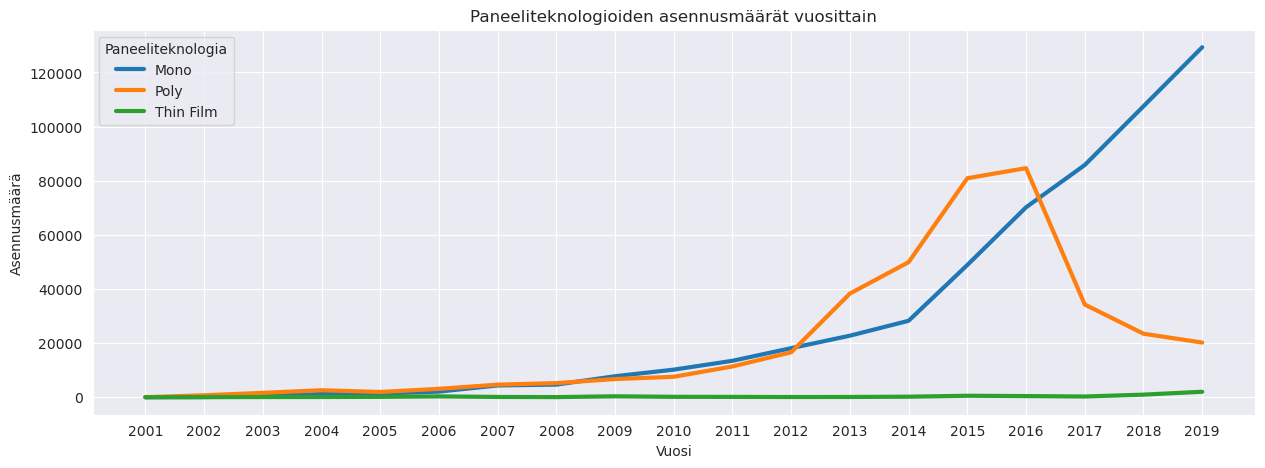

In [12]:
df = df_123.copy()

df = df[df['installation_date'] > '2001-01-01']
xticks = df['year'].unique()
df = df.groupby(['year'])['technology_module'].value_counts(normalize=False).unstack().dropna()

df.plot(grid=True, linewidth=3, figsize=(15,5), xlabel="Vuosi", ylabel="Asennusmäärä")
plt.title("Paneeliteknologioiden asennusmäärät vuosittain")
plt.xticks(xticks, labels=xticks)
plt.legend(labels=('Mono', 'Poly', 'Thin Film'), title='Paneeliteknologia')
sns.set_style("darkgrid")
plt.show()

## Paneeliteknologioiden hyötysuhteen kehitys

* Mono-teknologialla koko datan aikajaksolla 2013-2019 paras hyötysuhde.
* Poly-teknologian hyötysuhde nousee tasaisesti 13% -> 18%.
* Mono ja Thin Film -paneelien osalta hyötysuhde pääasiassa nousee, mutta vuosien 2009-2011 välillä myös laskee. Mikä voisi selittää tämän notkahduksen?
* Thin Film -paneelien hyötysuhteessa merkittävän jyrkkä kasvu lyhyessä ajassa vuosien 2012-2014 välillä.

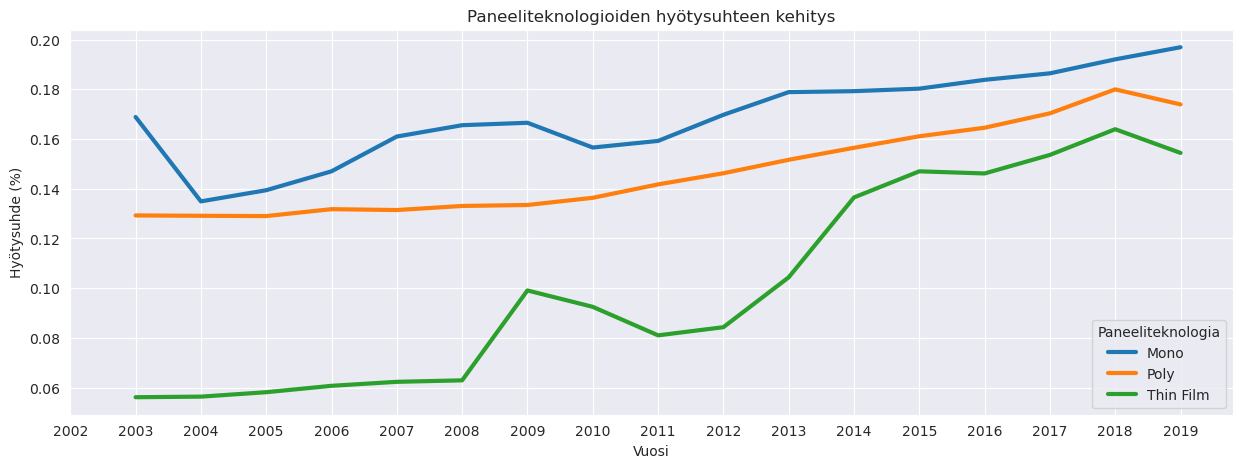

In [8]:
df = df_123.copy()

df = df[df['installation_date'] > '2002-01-01']
xticks = df['year'].unique()

df = df.groupby(['year', 'technology_module']).agg({'efficiency_module': 'mean'}).unstack().dropna()

df.plot(grid=True, linewidth=3, figsize=(15,5), xlabel="Vuosi", ylabel="Hyötysuhde (%)")
plt.title("Paneeliteknologioiden hyötysuhteen kehitys")
plt.xticks(xticks, labels=xticks)
plt.legend(labels=('Mono', 'Poly', 'Thin Film'), title='Paneeliteknologia')
sns.set_style("darkgrid")
plt.show()

## Paneeliteknologioiden hintatehosuhteen kehitys

* Asennuksista löytyy vain kokonaishinta, josta ei ole mahdollista eritellä mahdollisten eri teknologiaa olevien moduuleiden osuuksia erikseen.
* Kuvaajassa näytetään vain asennukset, joissa käytetty yhtä paneeliteknologiaa.
* Lisäksi käytetty esikäsittelijä-kirjastoa common-moodissa, jolla tehdään aiemmin sarakkeisiin määriteltyjä esikäsittelyjä automaattisesti.

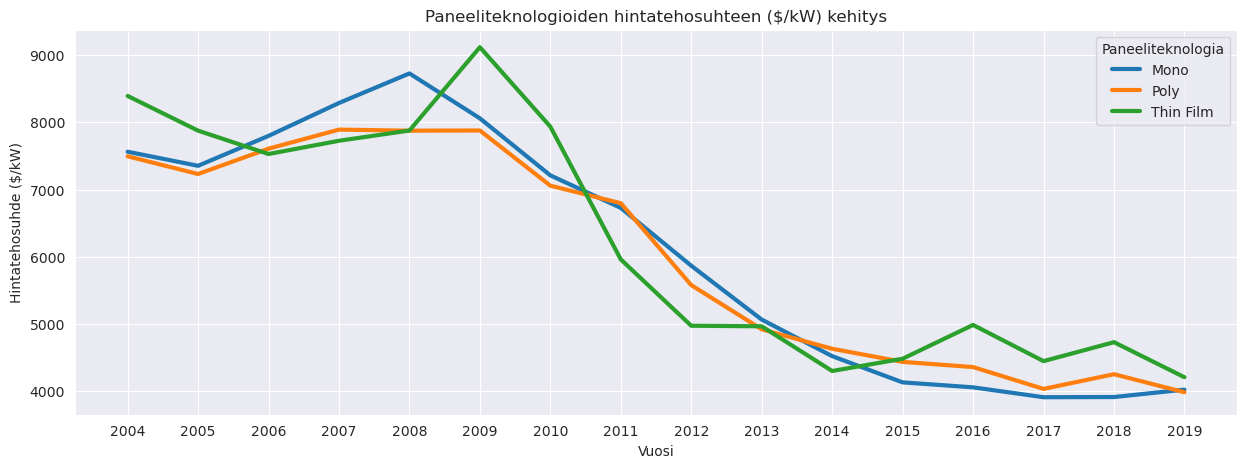

In [9]:
df = df_all.copy()

# pudotetaan pois asennukset, joissa käytetty samassa useampia eri teknologioita
df = df[(df['technology_module_2'].isna()) & (df['technology_module_3'].isna())]

df = df[df['installation_date'] > '2004-01-01']
xticks = df['year'].unique()

df = df.groupby(['year', 'technology_module_1']).agg({'price_per_kW': 'mean'}).unstack().dropna()

df.plot(grid=True, linewidth=3, figsize=(15,5), xlabel="Vuosi", ylabel="Hintatehosuhde ($/kW)")
plt.title("Paneeliteknologioiden hintatehosuhteen ($/kW) kehitys")
plt.xticks(xticks, labels=xticks)
plt.legend(labels=('Mono', 'Poly', 'Thin Film'), title='Paneeliteknologia')
sns.set_style("darkgrid")
plt.show()

## Paneeliteknologioiden keskimääräinen nimellisteho (W)

* Mono-teknologian paneelien keskimääräinen nimellisteho kaksinkertaisutunut 2007-2019 välillä ~150W -> 300W.
* Myös Poly-teknologian paneeleilla nimellisteho noussut tasaisesti.
* Thin Film-paneelien keskimääräinen nimellisteho 2003-2013 pieni ~100W, jonka jälkeen arvo 2.5 kertaistuu 2013-2019 välillä.

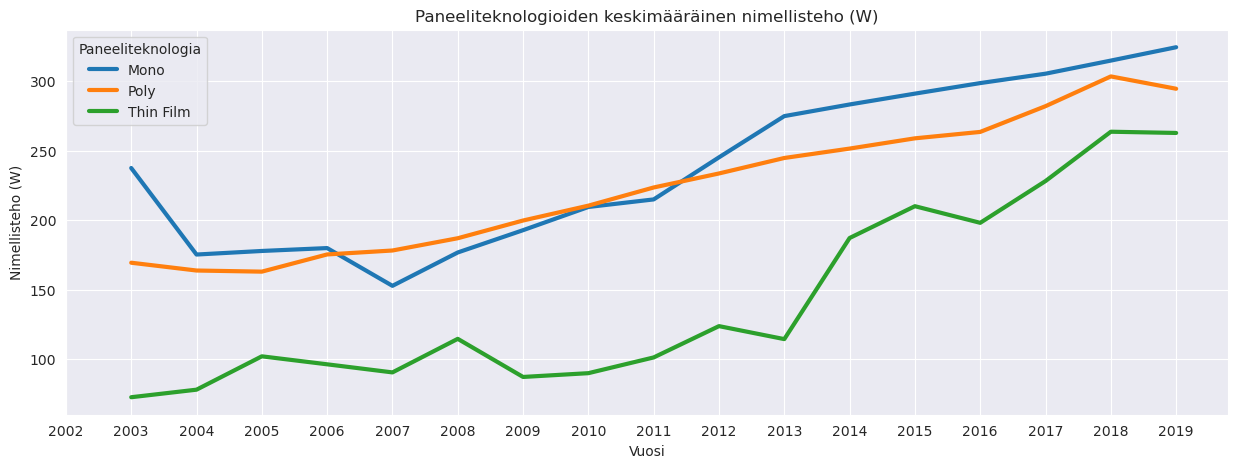

In [10]:
df = df_123.copy()

df = df[df['installation_date'] > '2002-01-01']
xticks = df['year'].unique()

df = df.groupby(['year', 'technology_module']).agg({'nameplate_capacity_module': 'mean'}).unstack().dropna()

df.plot(grid=True, linewidth=3, figsize=(15,5), xlabel="Vuosi", ylabel="Nimellisteho (W)")
plt.title("Paneeliteknologioiden keskimääräinen nimellisteho (W)")
plt.xticks(xticks, labels=xticks)
plt.legend(labels=('Mono', 'Poly', 'Thin Film'), title='Paneeliteknologia')
sns.set_style("darkgrid")
plt.show()

## Paneeliteknologioiden keskimääräinen paneelien määrä asennuksessa

* Mono- ja Poly-paneelien keskimääräiset asennuskohtaiset määrät eivät juuri aikajaksolla muutu.
* Thin Film-paneelien keskimääräiset asennuskohtaiset määrät heittelevät laajalla skaalalla ja ovat paikoin huomattavan isoja.

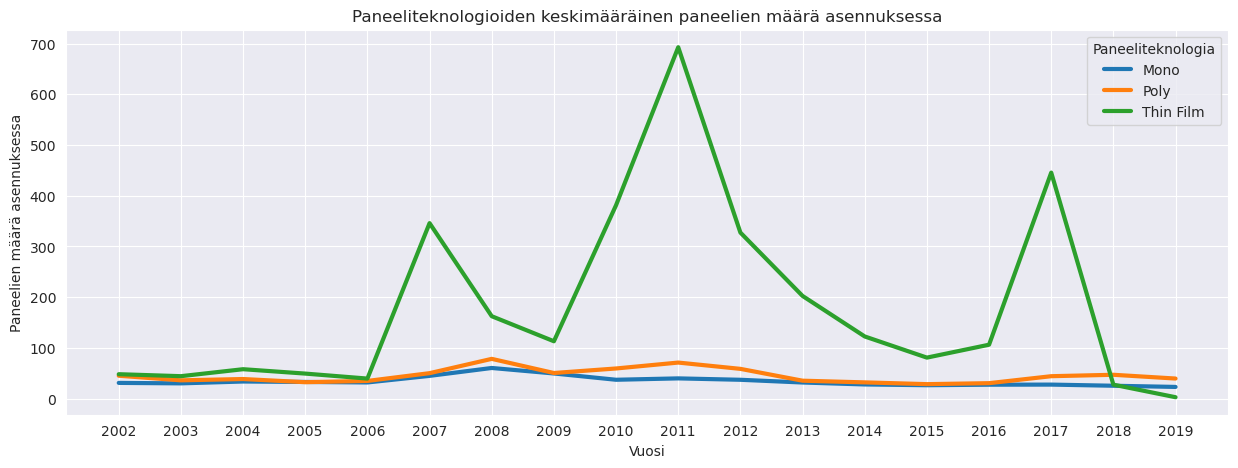

In [11]:
df = df_123.copy()

df = df[df['installation_date'] > '2002-01-01']
xticks = df['year'].unique()

df = df.groupby(['year', 'technology_module']).agg({'module_quantity': 'mean'}).unstack().dropna()

df.plot(grid=True, linewidth=3, figsize=(15,5), xlabel="Vuosi", ylabel="Paneelien määrä asennuksessa")
plt.title("Paneeliteknologioiden keskimääräinen paneelien määrä asennuksessa")
plt.xticks(xticks, labels=xticks)
plt.legend(labels=('Mono', 'Poly', 'Thin Film'), title='Paneeliteknologia')
sns.set_style("darkgrid")
plt.show()